In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statistics
import math

# Data

In [2]:
all_df = pd.read_csv("alldata.csv")
all_df.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Predictor

In [39]:
COLUMNS = ['GA', 'g_14088', 'g_15452', 'g_22824']
dataset = all_df.loc[all_df['Train'] == 1, COLUMNS]

In [40]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

# Inspect the data

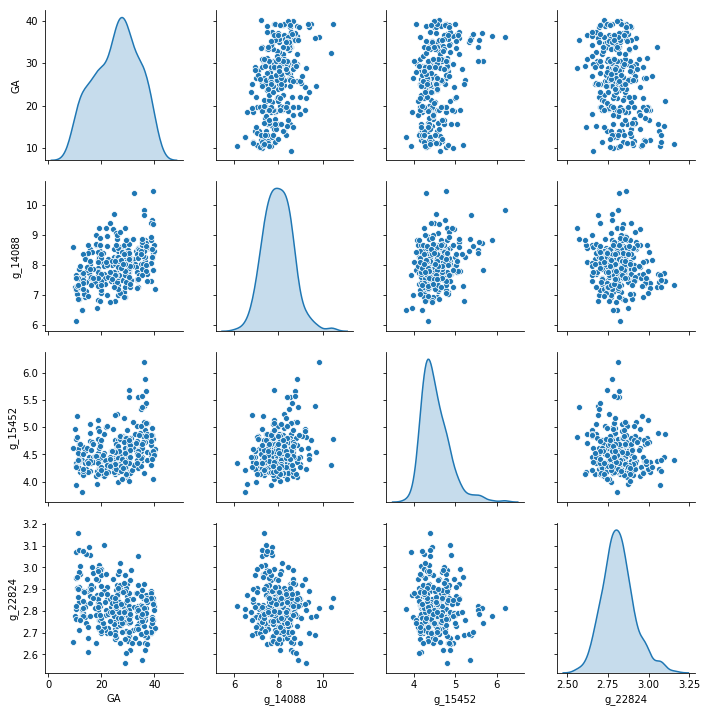

In [41]:
_ = sns.pairplot(train_dataset[COLUMNS], diag_kind = "kde")
plt.show()

In [42]:
train_stats = train_dataset.describe()
train_stats.pop('GA')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
g_14088,294.0,7.993257,0.652719,6.108016,7.532505,7.983732,8.430999,10.450518
g_15452,294.0,4.533031,0.342005,3.806468,4.290670,4.455434,4.708470,6.196941
g_22824,294.0,2.815380,0.098322,2.560439,2.754164,2.811795,2.867319,3.159517


# Split features from labels

In [43]:
train_labels = train_dataset.pop('GA')
test_labels = test_dataset.pop('GA')

In [79]:
train_labels.head()

215    25.3
556    22.0
88     27.9
59     36.6
150    22.4
Name: GA, dtype: float64

# Normalize the data

In [44]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [45]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [78]:
normed_train_data.head()

,g_14088,g_15452,g_22824
215,0.285603,-0.367954,0.051792
556,1.477057,-0.607211,0.389732
88,-0.545516,-0.507404,0.835183
59,0.869057,0.988496,-1.962829
150,0.319039,-0.958867,-0.930922


# Build the model

In [50]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = tf.nn.relu, input_shape = [len(train_dataset.keys())]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mean_squared_error',
                  optimizer = optimizer,
                  metrics = ['mean_absolute_error', 'mean_squared_error'])
    
    return model

In [51]:
model = build_model()

# Inspect the model

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


Take a batch of 10 examples from training data and call model.predict on it.

In [53]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.13279524],
       [-0.52860975],
       [-0.15752329],
       [-0.18430862],
       [-0.36315447],
       [-0.49084055],
       [-0.5571268 ],
       [-0.15994358],
       [-0.29062867],
       [-0.07129858]], dtype=float32)

# Train the model

Train the model for 1000 epochs, and records the training and validation accuracy in the history object.

In [55]:
# Display training process by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end = '')
        
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

# Visualize the training process

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,35.761878,4.715812,35.761879,50.277328,5.668914,50.277328,995
996,35.499019,4.699592,35.499020,52.661812,5.831375,52.661812,996
997,37.090911,4.777920,37.090912,49.916796,5.678699,49.916798,997
998,35.865026,4.690202,35.865028,50.119075,5.715720,50.119076,998
999,36.188824,4.713990,36.188828,49.373616,5.616910,49.373619,999


In [61]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [GA]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.ylim([0, 10])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$GA^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    plt.ylim([0, 80])
    plt.legend()
    plt.show()

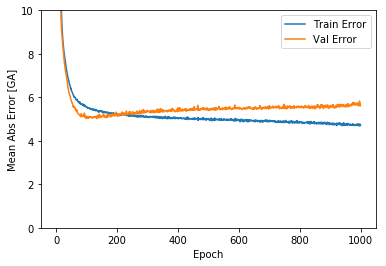

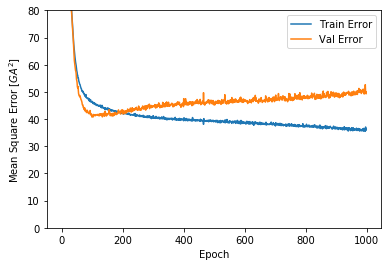

In [62]:
plot_history(history)

This graph shows little improvement or degradation in the validaiton error after about 100 epochs. Update the model.fit call to automatically stop training when the validation score doesn't improve. Use EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.


....................................................................................................
.............................

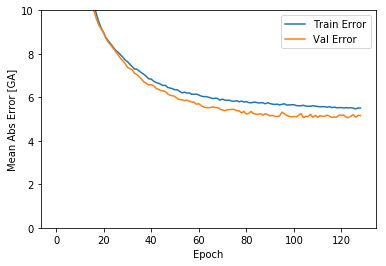

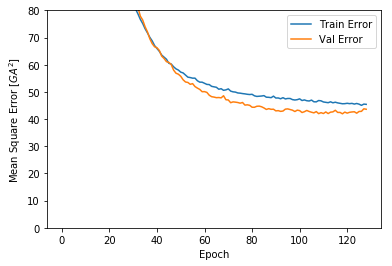

In [64]:
model = build_model()

# Patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS,
                    validation_split = 0.2, verbose = 0, 
                    callbacks = [early_stop, PrintDot()])

plot_history(history)

The first graph shows that on the validation set, the average error is usually around +/-5 GA.

See how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [67]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)

print("Testing set Mean Abs Error: {:5.2f} GA".format(mae))

Testing set Mean Abs Error:  5.78 GA


# Make predictions

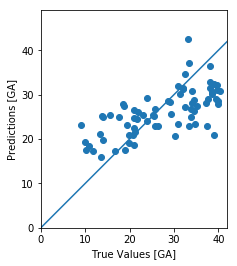

In [68]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [GA]')
plt.ylabel('Predictions [GA]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

The error distribution.

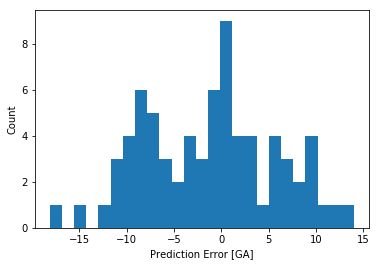

In [69]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [GA]")
_ = plt.ylabel("Count")

Calculate Root Mean Squared Error (RMSE).

In [96]:
rmse_nn = math.sqrt(statistics.mean((test_predictions - test_labels)**2))
print("RMSE by Neural Network regression: {:5.3f}".format(rmse_nn))

RMSE by Neural Network regression: 7.083


# Compare with OLS regression

In [82]:
print(type(normed_train_data))
print(normed_train_data.head())

print(type(train_labels))
print(train_labels.head())

print(type(normed_test_data))
print(normed_test_data.head())

print(type(test_labels))
print(test_labels.head())

<class 'pandas.core.frame.DataFrame'>
      g_14088   g_15452   g_22824
215  0.285603 -0.367954  0.051792
556  1.477057 -0.607211  0.389732
88  -0.545516 -0.507404  0.835183
59   0.869057  0.988496 -1.962829
150  0.319039 -0.958867 -0.930922
<class 'pandas.core.series.Series'>
215    25.3
556    22.0
88     27.9
59     36.6
150    22.4
Name: GA, dtype: float64
<class 'pandas.core.frame.DataFrame'>
     g_14088   g_15452   g_22824
16 -1.623582 -0.172157 -0.460479
57  0.046422 -0.054910 -0.293256
61 -1.187015  1.626907 -1.009323
68 -0.047231 -0.601445  1.364966
69 -1.234533 -1.107856 -1.238802
<class 'pandas.core.series.Series'>
16    13.3
57    18.6
61    37.6
68    19.9
69    17.6
Name: GA, dtype: float64


In [85]:
X = normed_train_data.values
X = sm.add_constant(X)
y = train_labels.values
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     36.39
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           5.45e-20
Time:                        21:07:59   Log-Likelihood:                -985.98
No. Observations:                 294   AIC:                             1980.
Df Residuals:                     290   BIC:                             1995.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7653      0.406     63.385      0.0

In-sample prediction

In [88]:
y_train_pred = result.predict(X)
y_train_pred[0:10]

array([25.69622502, 27.44384794, 21.7863016 , 33.75618774, 26.80353909,
       24.55496716, 24.19292294, 24.77743319, 33.36041669, 28.59172386])

In [90]:
X_test = normed_test_data.values
X_test = sm.add_constant(X_test)
y_test_pred = result.predict(X_test)
y_test_pred[0:10]

array([22.50224862, 26.39880588, 27.89940771, 21.70880902, 23.4291633 ,
       21.20441149, 23.97096832, 27.08302001, 22.84273888, 29.12441764])

In [99]:
rmse_ols = math.sqrt(statistics.mean((y_test_pred - test_labels)**2))
print("RMSE by Ordinary Least Square regression: {:5.3f}".format(rmse_ols))
print("RMSE by Neural Network regression: {:5.3f}".format(rmse_nn))

RMSE by Ordinary Least Square regression: 7.387
RMSE by Neural Network regression: 7.083
